In [25]:
import os
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi
 

In [29]:
load_dotenv()
# Authenticate Kaggle
api = KaggleApi()
api.authenticate()
dataset = "kartik2112/fraud-detection"
api.dataset_download_files(dataset, path="data", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection


In [44]:
import pandas as pd

train_df = pd.read_csv("data/fraudTrain.csv")
test_df = pd.read_csv("data/fraudTest.csv")

train_df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Percentage of each class:
is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


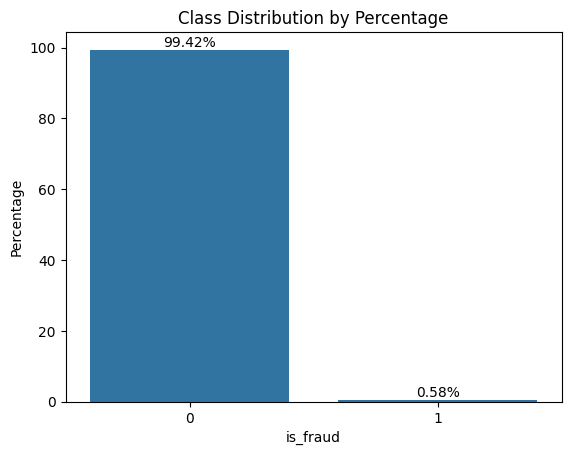

In [34]:
# 1. Calculate percentage of each class
percentages = train_df['is_fraud'].value_counts(normalize=True) * 100
print("Percentage of each class:")
print(percentages)

# 2. Plot using Seaborn (y-axis as percentage) - Seaborn 0.13+ required
ax = sns.countplot(x='is_fraud', data=train_df, stat='percent')
plt.ylabel("Percentage")
plt.title("Class Distribution by Percentage")

# 3. Add percentage labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

### we can clearly see that there is a imbalance in the dataset. if we train without balacing the model will be biased towards class 0 i.e it will always predict as non fradulant activity , that brings no value to the problem
### normally we solve imbalance by diff techniques: 
1. data level : 
    Oversampling : synthetically generate minority class samples ( e,g using SMOTE)
    undersampling : reduce the no of majority samples
    combine oversampling and undersampling : do both 
2. Algorithm level : this happens at the model training , when the loss function computes the error for each sample 
    class weights : the error for minority sample is multiplied by higher weights 

### but there is a catch since the minority class percentage is very low , we can say that the probability of this event happening is rare, so we can go with anomaly detection for this we use the imbalanced data 

The idea is to train only on normal behavior and treat fraud as outliers.
     

In [36]:
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

In [37]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)
print(" Combined dataset shape:", df.shape)

 Combined dataset shape: (1852394, 23)


In [38]:
target_col = "is_fraud"

# Remove extreme transaction amounts
df = df[(df["amt"] >= 5) & (df["amt"] <= 1250)]

# Transaction time
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], errors="coerce")
df["trans_hour"] = df["trans_date_trans_time"].dt.hour
df["trans_dayofweek"] = df["trans_date_trans_time"].dt.dayofweek

# DOB->age
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")
today = pd.to_datetime("2020-12-31")
df["age"] = (today - df["dob"]).dt.days // 365

# Drop irrelevant columns
drop_cols = ["trans_date_trans_time", "cc_num", "first", "last", "street",
             "zip", "dob", "unix_time", "merchant", "trans_num"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Encode categorical columns
cat_cols = ["gender", "category", "city", "state", "job"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].fillna("missing").astype(str)
        df[c] = LabelEncoder().fit_transform(df[c])

# Fill missing values
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

In [39]:
print("Original distribution:", Counter(df[target_col]))
fraud = df[df[target_col] == 1]
nonfraud = df[df[target_col] == 0].sample(n=len(fraud), random_state=42)
df_bal = pd.concat([fraud, nonfraud]).sample(frac=1, random_state=42)
print("After:", Counter(df_bal[target_col]))

X = df_bal.drop(columns=[target_col])
y = df_bal[target_col]

Original distribution: Counter({0: 1607761, 1: 9592})
After: Counter({1: 9592, 0: 9592})


In [40]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train/Test:", X_train.shape, X_test.shape)

Train/Test: (15347, 15) (3837, 15)


In [41]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42
    )
}

results = []
for name, model in models.items():
    print(f"\n Training {name} :")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    res = {
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_test, y_pred, zero_division=0), 4),
        "Specificity": round(specificity, 4),
        "F1-Score": round(f1_score(y_test, y_pred, zero_division=0), 4),
        "AUC": round(auc, 4)
    }
    results.append(res)
    print(res)


 Training RandomForest :
{'Model': 'RandomForest', 'Accuracy': 0.9679, 'Precision': 0.9746, 'Recall': 0.9609, 'Specificity': np.float64(0.975), 'F1-Score': 0.9677, 'AUC': 0.9947}

 Training DecisionTree :
{'Model': 'DecisionTree', 'Accuracy': 0.9679, 'Precision': 0.9662, 'Recall': 0.9698, 'Specificity': np.float64(0.9661), 'F1-Score': 0.968, 'AUC': 0.9679}

 Training LogisticRegression :
{'Model': 'LogisticRegression', 'Accuracy': 0.8533, 'Precision': 0.934, 'Recall': 0.7602, 'Specificity': np.float64(0.9463), 'F1-Score': 0.8382, 'AUC': 0.8419}

 Training GradientBoosting :
{'Model': 'GradientBoosting', 'Accuracy': 0.9682, 'Precision': 0.9711, 'Recall': 0.9651, 'Specificity': np.float64(0.9713), 'F1-Score': 0.9681, 'AUC': 0.9953}


In [42]:
results_df = pd.DataFrame(results)
results_df.to_csv("model_comparison_results.csv", index=False)
joblib.dump(models["GradientBoosting"], "gradient_boosting_model.joblib")

print("\n Model comparison results")
print(results_df)

print("\nGradient Boosting:")
print(classification_report(y_test, models["GradientBoosting"].predict(X_test), zero_division=0))


 Model comparison results
                Model  Accuracy  Precision  Recall  Specificity  F1-Score  \
0        RandomForest    0.9679     0.9746  0.9609       0.9750    0.9677   
1        DecisionTree    0.9679     0.9662  0.9698       0.9661    0.9680   
2  LogisticRegression    0.8533     0.9340  0.7602       0.9463    0.8382   
3    GradientBoosting    0.9682     0.9711  0.9651       0.9713    0.9681   

      AUC  
0  0.9947  
1  0.9679  
2  0.8419  
3  0.9953  

Gradient Boosting:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1919
           1       0.97      0.97      0.97      1918

    accuracy                           0.97      3837
   macro avg       0.97      0.97      0.97      3837
weighted avg       0.97      0.97      0.97      3837




Confusion Matrix: Gradient Boosting


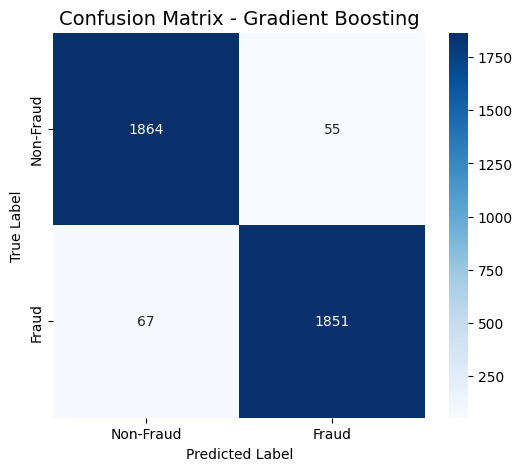

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    labels = ['Non-Fraud', 'Fraud']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {title}', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot for Gradient Boosting
print("\nConfusion Matrix: Gradient Boosting")
plot_conf_matrix(models["GradientBoosting"], X_test, y_test, "Gradient Boosting")